In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics

In [38]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [39]:
def prepare_data(series, n_test, n_in, n_out):
    values = series.values
    supervised_data = series_to_supervised(values, n_in, n_out)
    print('supervised_data', supervised_data)
    train, test = supervised_data.loc[:3500, :], supervised_data.loc[3501:, :]
    return train, test

In [40]:
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # print('train', train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # print('trainX', trainX, 'trainy', trainy)
    # fit model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [41]:
def walk_forward_validation(train, test):
    predictions = list()
    train = train.values
    history = [x for x in train]
    # print('history', history)
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # print('i', i, testX, testy)
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i+1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1],predictions

In [42]:
def evaluation_metric(y_test,y_hat):
    MSE = metrics.mean_squared_error(y_test, y_hat)
    RMSE = MSE**0.5
    MAE = metrics.mean_absolute_error(y_test,y_hat)
    R2 = metrics.r2_score(y_test,y_hat)
    print('MSE: %.5f' % MSE)
    print('RMSE: %.5f' % RMSE)
    print('MAE: %.5f' % MAE)
    print('R2: %.5f' % R2)

In [43]:
data = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\TCS.csv")
data.index = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
# data = pd.DataFrame(data, dtype=np.float64)
close = data.pop('Close')
data.insert(4, 'Close', close)
data1 = data.iloc[3501:, 4]
residuals = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\ARIMA_residuals1.csv")
residuals.index = pd.to_datetime(residuals['Date'])
residuals.pop('Date')
merge_data = pd.merge(data, residuals, on='Date')
#merge_data = merge_data.drop(labels='2007-01-04', axis=0)
time = pd.Series(data.index[3501:])

In [44]:
print(len(data1),len(time))

180 180


In [45]:
Lt = pd.read_csv("C:\MTech\Second Semester\Advanced Time Series Analysis(IT833)\Project\Data\ARIMA.csv")
Lt = Lt.drop('Date', axis=1)
Lt = np.array(Lt)
Lt = Lt.flatten().tolist()

In [46]:
train, test = prepare_data(merge_data, n_test=180, n_in=6, n_out=1)

supervised_data         var1(t-6)    var2(t-6)    var3(t-6)   var4(t-6)    var5(t-6)  \
6      220.512497   232.500000   217.537506  16209848.0   227.637497   
7      229.024994   233.937500   226.625000   9487980.0   230.250000   
8      231.250000   240.500000   231.000000   5298780.0   235.937500   
9      236.250000   237.375000   230.287506   3613764.0   231.862503   
10     227.500000   237.500000   218.149994   3982796.0   234.262497   
...           ...          ...          ...         ...          ...   
3676  3150.500000  3221.399902  3144.000000   6739966.0  3179.300049   
3677  3169.649902  3169.649902  3095.050049   2289468.0  3143.300049   
3678  3143.300049  3156.750000  3097.449951   1815297.0  3106.100098   
3679  3130.050049  3143.500000  3106.100098   1123939.0  3130.800049   
3680  3114.899902  3146.350098  3101.000000   1372218.0  3124.649902   

       var6(t-6)    var1(t-5)    var2(t-5)    var3(t-5)   var4(t-5)  ...  \
6     227.637497   229.024994   233.937500 

1 >expected=-51.816697, predicted=-33.494877
2 >expected=-41.533888, predicted=-25.274912
3 >expected=-6.242798, predicted=-10.775049
4 >expected=67.388104, predicted=7.302493
5 >expected=11.294117, predicted=46.276646
6 >expected=93.190533, predicted=-17.770439
7 >expected=13.810522, predicted=13.593375
8 >expected=-2.846314, predicted=-3.873903
9 >expected=-3.854371, predicted=-5.088626
10 >expected=-51.124569, predicted=-6.126950
11 >expected=72.279907, predicted=4.152277
12 >expected=70.518923, predicted=23.331764
13 >expected=44.804945, predicted=52.236244
14 >expected=-0.048433, predicted=-3.029751
15 >expected=-5.510059, predicted=-14.174185
16 >expected=47.515271, predicted=1.166894
17 >expected=15.674997, predicted=4.485445
18 >expected=12.009087, predicted=-13.529676
19 >expected=10.069743, predicted=17.076630
20 >expected=-19.733776, predicted=18.599842
21 >expected=68.391178, predicted=17.223221
22 >expected=-21.002181, predicted=1.052064
23 >expected=-6.553995, predicted=1

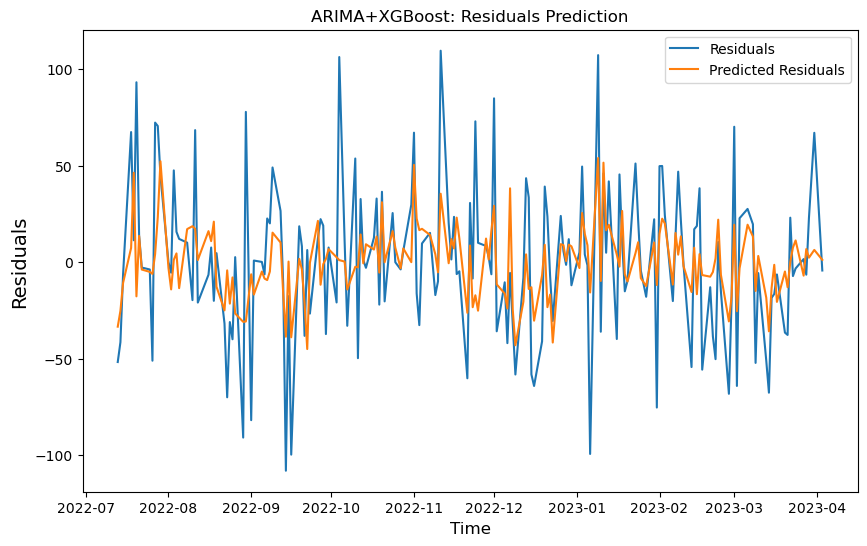

In [47]:
y, yhat = walk_forward_validation(train, test)
plt.figure(figsize=(10, 6))
plt.plot(time, y, label='Residuals')
plt.plot(time, yhat, label='Predicted Residuals')
plt.title('ARIMA+XGBoost: Residuals Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Residuals', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

MSE: 4576.84882
RMSE: 67.65241
MAE: 56.22975
R2: 0.76157


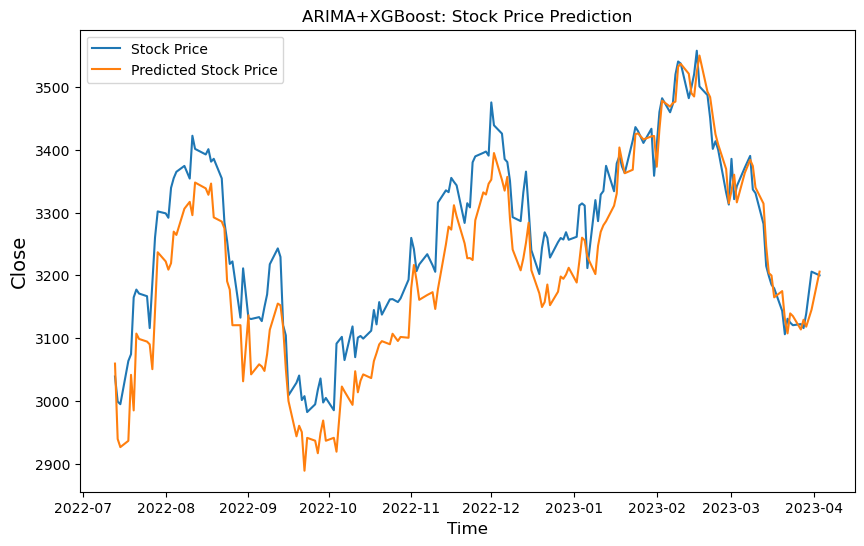

In [48]:
finalpredicted_stock_price = [i + j for i, j in zip(Lt, yhat)]
#print('final', finalpredicted_stock_price)
evaluation_metric(data1, finalpredicted_stock_price)
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Stock Price')
plt.plot(time, finalpredicted_stock_price, label='Predicted Stock Price')
plt.title('ARIMA+XGBoost: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()